Cargando datos de entrenamiento...

Visualizando la serie de tiempo de casos de dengue...


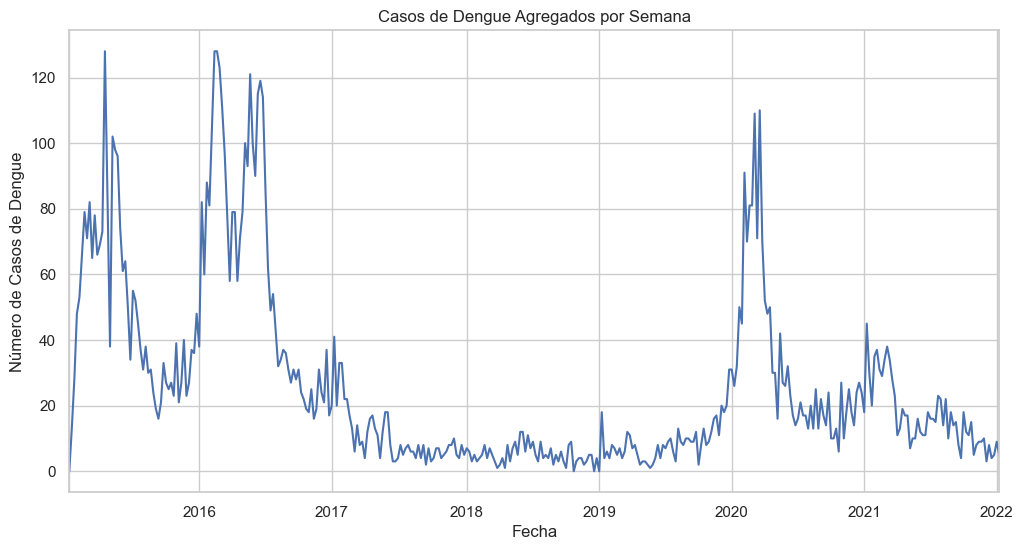

[I 2025-06-17 23:48:43,734] A new study created in memory with name: no-name-6d861316-d5eb-4fdd-8af9-d4ab011a4b74



--- Iniciando optimización de hiperparámetros para LSTM con PyTorch y Optuna ---

Iniciando la búsqueda de hiperparámetros con Optuna. Esto puede tardar varios minutos...


c:\Git\ICESI\FA_TALLER2\venv\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [32, 200] and step=16, but the range is not divisible by `step`. It will be replaced by [32, 192].
  warnings.warn(
[I 2025-06-17 23:48:46,852] Trial 0 finished with value: 6.3118779461155885 and parameters: {'time_step': 40, 'hidden_layer_size': 176, 'dropout_rate': 0.39304131572178946, 'learning_rate': 0.0016294952805719508, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 6.3118779461155885.
c:\Git\ICESI\FA_TALLER2\venv\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [32, 200] and step=16, but the range is not divisible by `step`. It will be replaced by [32, 192].
  warnings.warn(
[I 2025-06-17 23:48:59,534] Trial 1 finished with value: 6.4666334488527335 and parameters: {'time_step': 39, 'hidden_layer_size': 128, 'dropout_rate': 0.3956393895248853, 'learning_rate': 0.0003335986968636459, 'optimizer'


Búsqueda de hiperparámetros completada.
Mejor trial: RMSE = 5.9943
Mejores hiperparámetros encontrados:
  time_step: 60
  hidden_layer_size: 192
  dropout_rate: 0.3161850392077567
  learning_rate: 0.0004014650408066401
  optimizer: RMSprop
  batch_size: 16

--- Entrenando el modelo final con los mejores hiperparámetros... ---
Epoch:  25 loss: 0.00009894
Epoch:  50 loss: 0.00450096
Epoch:  75 loss: 0.00171263
Epoch: 100 loss: 0.00039338
Epoch: 125 loss: 0.00067307
Epoch: 150 loss: 0.00003312


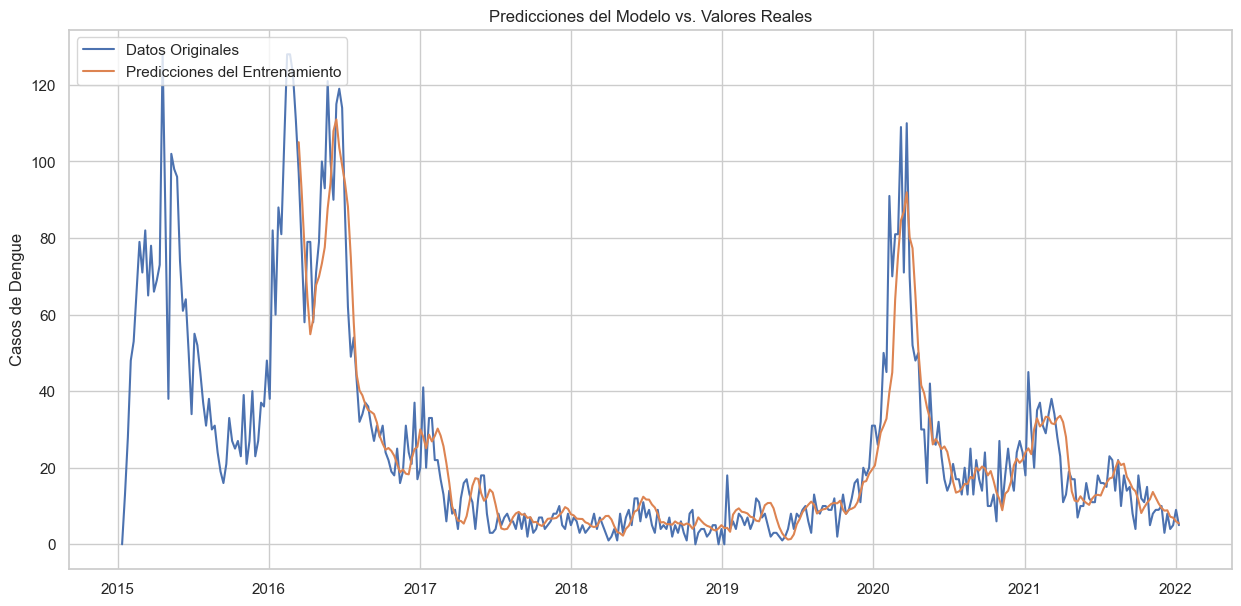


Proceso completado.


In [4]:
# -*- coding: utf-8 -*-
"""
Análisis Exploratorio de Datos (EDA) y Optimización de Hiperparámetros
de un modelo LSTM con PyTorch y Optuna para la predicción de Casos de Dengue.

Este script realiza lo siguiente:
1. Carga y prepara los datos de entrenamiento desde un archivo Parquet.
2. Realiza un EDA de la serie de tiempo.
3. Implementa una red LSTM usando PyTorch.
4. Utiliza Optuna para encontrar los mejores hiperparámetros para el modelo LSTM.
5. Entrena el modelo final con los mejores hiperparámetros y visualiza los resultados.
"""

# 1. Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import optuna

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- ANÁLISIS DEL CONJUNTO DE ENTRENAMIENTO (df_train.parquet) ---

# 2. Carga y Preparación de Datos
print("Cargando datos de entrenamiento...")
try:
    # Cargar desde el formato Parquet en el directorio especificado
    # Asegúrate de tener instalada una librería como pyarrow o fastparquet
    df_train = pd.read_parquet('../../Datos/df_train.parquet')
    df_train['date'] = pd.to_datetime(df_train['anio'].astype(str) + '-' + df_train['semana'].astype(str) + '-1', format='%Y-%W-%w')
    df_train.set_index('date', inplace=True)
except FileNotFoundError:
    # Actualizar el mensaje de error
    print("Error: '../../Datos/df_train.parquet' no encontrado. Asegúrate de que el archivo está en la ruta correcta.")
    exit()

# 3. Agregación y Visualización de la Serie de Tiempo
dengue_series = df_train['dengue'].resample('W').sum()
print("\nVisualizando la serie de tiempo de casos de dengue...")
dengue_series.plot(title='Casos de Dengue Agregados por Semana')
plt.ylabel('Número de Casos de Dengue')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

# --- COMIENZO DE LA IMPLEMENTACIÓN DE LSTM CON PYTORCH Y OPTUNA ---

print("\n--- Iniciando optimización de hiperparámetros para LSTM con PyTorch y Optuna ---")

# 4. Preparación de Datos para LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dengue_series.values.reshape(-1, 1))

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 5. Definición del Modelo LSTM en PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, dropout_rate, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # Tomamos solo la última salida de la secuencia
        last_output = lstm_out[:, -1, :]
        predictions = self.linear(self.dropout(last_output))
        return predictions

# 6. Definición de la Función Objetivo de Optuna
def objective(trial):
    # Sugerir Hiperparámetros
    time_step = trial.suggest_int('time_step', 10, 60)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 32, 200, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Crear secuencias y convertirlas a tensores de PyTorch
    X, y = create_dataset(scaled_data, time_step)
    if len(X) < 2: return float('inf')
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    X_train_tensor = torch.from_numpy(X_train).float().reshape(-1, time_step, 1)
    y_train_tensor = torch.from_numpy(y_train).float().reshape(-1, 1)
    X_val_tensor = torch.from_numpy(X_val).float().reshape(-1, time_step, 1)
    y_val_tensor = torch.from_numpy(y_val).float().reshape(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Construir el Modelo, Pérdida y Optimizador
    model = LSTMModel(input_size=1, hidden_layer_size=hidden_layer_size, dropout_rate=dropout_rate)
    loss_function = nn.MSELoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    # Bucle de Entrenamiento
    epochs = 100
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for seq, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, labels in val_loader:
                y_pred_val = model(seq)
                val_loss += loss_function(y_pred_val, labels).item()
        
        val_loss /= len(val_loader)
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            # print(f'Early stopping at epoch {epoch+1}')
            break

    # Cargar el mejor modelo y Evaluar
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds = []
    with torch.no_grad():
        for seq, _ in val_loader:
            y_pred_eval = model(seq)
            all_preds.append(y_pred_eval.numpy())
    
    predictions = np.concatenate(all_preds)
    predictions_inv = scaler.inverse_transform(predictions)
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_val_inv, predictions_inv))
    return rmse

# 7. Ejecución del Estudio de Optuna
print("\nIniciando la búsqueda de hiperparámetros con Optuna. Esto puede tardar varios minutos...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600) # 50 trials o 10 minutos

# 8. Resultados de la Optimización
print("\nBúsqueda de hiperparámetros completada.")
print(f"Mejor trial: RMSE = {study.best_value:.4f}")
print("Mejores hiperparámetros encontrados:")
best_params = study.best_params
for key, value in best_params.items():
    print(f"  {key}: {value}")

# --- ENTRENAMIENTO Y PREDICCIÓN CON EL MEJOR MODELO ---

print("\n--- Entrenando el modelo final con los mejores hiperparámetros... ---")

# 9. Preparar datos y entrenar el modelo final
time_step = best_params['time_step']
X, y = create_dataset(scaled_data, time_step)
X_tensor = torch.from_numpy(X).float().reshape(-1, time_step, 1)
y_tensor = torch.from_numpy(y).float().reshape(-1, 1)

final_train_dataset = TensorDataset(X_tensor, y_tensor)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params['batch_size'], shuffle=True)

final_model = LSTMModel(input_size=1, hidden_layer_size=best_params['hidden_layer_size'], dropout_rate=best_params['dropout_rate'])
loss_function = nn.MSELoss()
optimizer = getattr(optim, best_params['optimizer'])(final_model.parameters(), lr=best_params['learning_rate'])

# Bucle de entrenamiento final (sin validación, entrenamos en todos los datos)
epochs = 150 # Entrenamos un poco más en el set final
for i in range(epochs):
    for seq, labels in final_train_loader:
        optimizer.zero_grad()
        final_model.train()
        y_pred = final_model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if (i+1)%25 == 0:
        print(f'Epoch: {i+1:3} loss: {single_loss.item():.8f}')

# 10. Visualización de las predicciones del modelo final
final_model.eval()
with torch.no_grad():
    train_predictions_scaled = final_model(X_tensor)

# Invertir escala
train_predictions = scaler.inverse_transform(train_predictions_scaled.numpy())
y_original = scaler.inverse_transform(y_tensor.numpy())

# Crear un DataFrame para la visualización
predict_index_start = dengue_series.index[time_step + 1]
predict_index_end = dengue_series.index[-1]
# Asegurarse de que los índices coinciden
predict_index = dengue_series.index[len(dengue_series) - len(train_predictions):]

plt.figure(figsize=(15,7))
plt.title('Predicciones del Modelo vs. Valores Reales')
plt.ylabel('Casos de Dengue')
plt.grid(True)
plt.plot(dengue_series.index, dengue_series.values, label='Datos Originales')
plt.plot(predict_index, train_predictions, label='Predicciones del Entrenamiento')
plt.legend(loc='upper left')
plt.show()

print("\nProceso completado.")
